## Multi-Layer Perceptron for Approximate Low-thrust Transfers

This notebook is for training a Multi-layer Perceptron (MLP) for approximating cost of low-thrust trajectories in the Main Asteroid Belt (MAB). The work is based on the paper: [Acciarini, G., Beauregard, L., & Izzo, D. (2024), Computing low-thrust transfers in the asteroid belt, a comparison between astrodynamical manipulations and a machine learning approach.](https://www.researchgate.net/publication/380974504_Computing_low-thrust_transfers_in_the_asteroid_belt_a_comparison_between_astrodynamical_manipulations_and_a_machine_learning_approach/figures)

And the dataset is downloaded from the [Zenodo link](https://data.niaid.nih.gov/resources?id=zenodo_10972837) provided by the authors. In particular, the ```fuel_optimal_db.txt``` is used and modified accordingly to be read as a ```.csv``` (e.g., adding commas and removing spaces from the columns' names).

### Step 0: Import libraries

In this step, libraries are imported. [Tensorflow](https://www.tensorflow.org) is used to build the MLP architecture.

In [1]:
# import the libraries
import tensorflow as tf
from keras._tf_keras.keras import layers
import keras

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

### Step 1: Data preparation

The dataset is loaded and processed. In particular, the columns ```["mima [kg]", "mima2 [kg]", "mima3 [kg]", "mfms_approx"]``` are dropped as these only represent other approximations to the described transfers, thus not adding much to the MLP predictions.

The predicted value should be the ratio between the target mass of the spacecraft at the end of the transfer (i.e., ```mt [kg]```) and the initial mass (i.e., ```ms [kg]```). In this way, the output variable is in the range ```[0-1]```.

A train-test split is performed, assuming 20% of the dataset used for testing.

The train set is fitted and scaled by centering and scaled, while the test set is only scaled. This allows to simulate the fact that unseen data are passed to the model.

In [2]:
# define the file path
file_path = "datasets/fuel_optimal_db.csv"

# Load the data using pandas
data = pd.read_csv(file_path)

# drop unused columns
columns_to_drop = ["mima [kg]", "mima2 [kg]", "mima3 [kg]", "mfms_approx"]
data = data.drop(columns=columns_to_drop)

# Preprocess data
y = data["mt [kg]"] / data["ms [kg]"] # put the data in 0-1 range
X = data.drop("mt [kg]", axis=1)

# split data in train and test -- 20% of the dataset is used for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Step 2: MLP

A simple MLP is built using an input and normalization layers, followed by 2 hidden layers with 64 and 32 neurons, respectively. The output layer only has one neuron since a single value is desired as target. A sigmoid is used as activation function for output layer, since it is expected that the output is in the ```[0-1]``` range.

The loss is mean squared error (MSE), while the metric is the mean absolute error (MAE). 

In [3]:
# Multi Layer Perceptron

# initialize the model
model = keras.Sequential(
    [
        layers.InputLayer(shape=(X_train.shape[1],)),
        layers.BatchNormalization(),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid"),
    ]
)

# compile the model
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_absolute_error"])

The model is then trained for 10 epochs.

In [4]:
# train the model
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=10,
    verbose=1,
    batch_size=32,
)

Epoch 1/10
33188/33188 ━━━━━━━━━━━━━━━━━━━━ 38s 1ms/step - loss: 0.0036 - mean_absolute_error: 0.0379
Epoch 2/10
33188/33188 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step - loss: 0.0011 - mean_absolute_error: 0.0255
Epoch 3/10
33188/33188 ━━━━━━━━━━━━━━━━━━━━ 33s 1ms/step - loss: 0.0011 - mean_absolute_error: 0.0251
Epoch 4/10
33188/33188 ━━━━━━━━━━━━━━━━━━━━ 31s 924us/step - loss: 0.0011 - mean_absolute_error: 0.0249
Epoch 5/10
33188/33188 ━━━━━━━━━━━━━━━━━━━━ 31s 937us/step - loss: 0.0011 - mean_absolute_error: 0.0248
Epoch 6/10
33188/33188 ━━━━━━━━━━━━━━━━━━━━ 31s 933us/step - loss: 0.0010 - mean_absolute_error: 0.0247
Epoch 7/10
33188/33188 ━━━━━━━━━━━━━━━━━━━━ 31s 923us/step - loss: 0.0010 - mean_absolute_error: 0.0247
Epoch 8/10
33188/33188 ━━━━━━━━━━━━━━━━━━━━ 31s 936us/step - loss: 0.0010 - mean_absolute_error: 0.0246
Epoch 9/10
33188/33188 ━━━━━━━━━━━━━━━━━━━━ 30s 910us/step - loss: 0.0010 - mean_absolute_error: 0.0246
Epoch 10/10
33188/33188 ━━━━━━━━━━━━━━━━━━━━ 31s 935us/step - loss: 0.

In [5]:
# evaluate and check the history
test_loss = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_test_scaled)
train_mae = history.history["mean_absolute_error"]

8297/8297 ━━━━━━━━━━━━━━━━━━━━ 5s 623us/step - loss: 8.6736e-04 - mean_absolute_error: 0.0223
8297/8297 ━━━━━━━━━━━━━━━━━━━━ 5s 628us/step


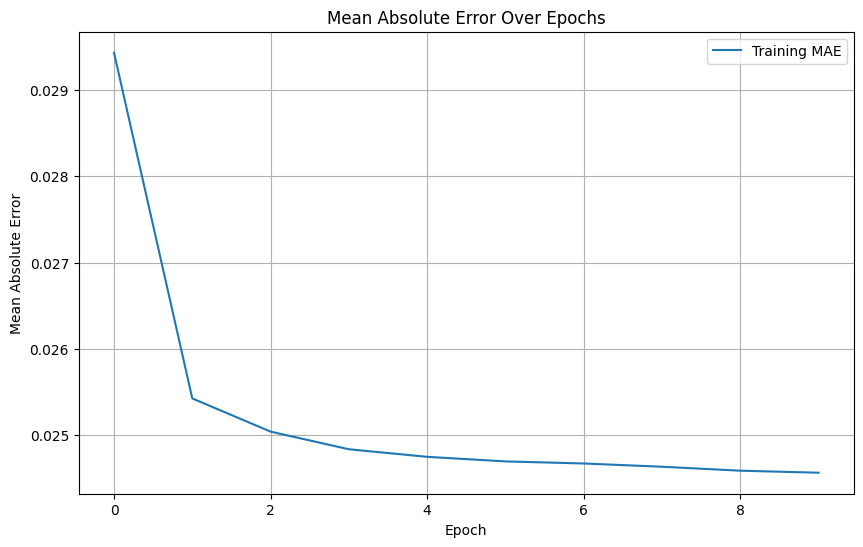

In [6]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(train_mae, label='Training MAE')
plt.title('Mean Absolute Error Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [7]:
predictions = model.predict(X_test_scaled)

8297/8297 ━━━━━━━━━━━━━━━━━━━━ 5s 558us/step


In [8]:
# mean percentage error
mpe = sum(abs(y_pred.flatten() - y_test.to_numpy())/y_test.to_numpy())/len(y_test) * 100